In [1]:
import datetime as dt
import os
import locale
locale.setlocale(locale.LC_ALL,'de_DE')
from zoneinfo import ZoneInfo
tz = ZoneInfo('Europe/Berlin')

import numpy as np
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from matplotlib.backends.backend_pdf import PdfPages
plt.style.use('./src/stylesheets/eb3.mplstyle')

from src.utilities import set_ticks, recolor_lines, export, DIN, INDOC, eb_bbox, PeriodToDatetimeIndex
from src.project_definitions import dir_results
from src.update_databases import up
from src.sensor_reader import import_data
from src.Wetter import weather109

### update database ###
up()

### import database ###
print('Starte Import der Datensätze - das kann etwas dauern...')
AMB = import_data(mode='AMB', startdate=None, timestep='60min')
print('...Import beendet')

30.03.2022 16:41:55 -- INFO -- ------ Starte TinkerForge Update------
30.03.2022 16:41:55 -- INFO -- MH wurde übersprungen.
30.03.2022 16:41:55 -- INFO -- MW wurde übersprungen.
30.03.2022 16:41:55 -- INFO -- LB wurde übersprungen.
30.03.2022 16:41:55 -- INFO -- PM wurde übersprungen.
30.03.2022 16:41:55 -- INFO -- WD wurde übersprungen.
30.03.2022 16:41:55 -- INFO -- ------TinkerForge Update beendet!------
30.03.2022 16:41:55 -- INFO -- Molline-Datenbank up-to-date. Kein Update notwendig.


Starte Import der Datensätze - das kann etwas dauern...
...Import beendet


In [2]:
ex = False

In [3]:
if not ex:
    # Monat
    focus = '3 2022'
    
    month, year = focus.split()
    focus_month = dt.date(int(year),int(month),1)

## Wetterdaten
____

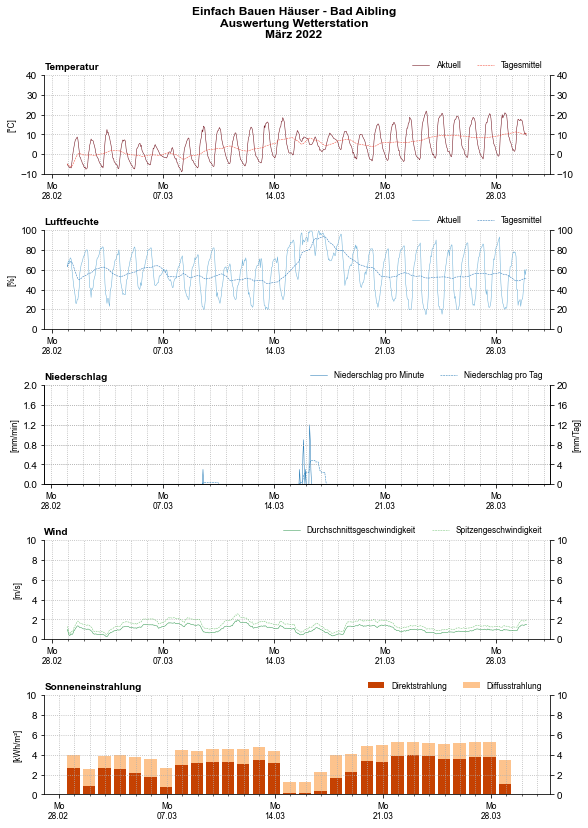

In [4]:
if not os.path.isdir(os.path.join(dir_results,'Wetterstation')):os.makedirs(os.path.join(dir_results,'Wetterstation'))
with PdfPages(os.path.join(dir_results,'Wetterstation','Wetter_monatlich.pdf')) as pdf:
    for date, amb in AMB.groupby(by=[AMB.index.month, AMB.index.year]):
        date = dt.date(date[1], date[0], 1)
        if not ex and date != focus_month:
            continue
        fig, axs = plt.subplots(5,1,figsize=DIN['A4'])
        fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\n{date.strftime("%B %Y")}\n', fontweight = 'bold')
        i=0
        #----#1: Temperaturen ----
        axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[°C]')
        set_ticks(axs[i],-10,40,10)
        axs[i].plot(amb.T_amb,label='Aktuell')
        axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        recolor_lines(axs[i], 'Reds_r', 0 ,0.8)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#2: Luftfeuchte ----
        axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[%]')
        set_ticks(axs[i],0,100,20)
        axs[i].plot(amb.Rh_amb,label='Aktuell')
        axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        recolor_lines(axs[i], 'Blues', 0.5,1)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Niederschlag ----
        # Plot aktueller Niederschlag (pro Minute)
        axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[mm/min]')
        
        axs[i].plot(amb.rain.diff(),label='Niederschlag pro Minute')
        han,lab = axs[i].get_legend_handles_labels()
        axs[i].grid(axis='y', ls = 'dotted')
        i+=1

        #Plot summierter Niederschlag pro Tag

        axs = np.insert(axs,i,axs[i-1].twinx())
        axs[i].set_ylabel('[mm/Tag]')
        axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
        set_ticks(axs[i],0,20,4)
        set_ticks(axs[i-1], 0, 2, 0.4)
        han2,lab2 = axs[i].get_legend_handles_labels()
        lab += lab2
        han += han2
        axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Wind ----

        axs[i].set_title('Wind', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[m/s]')
        axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Durchschnittsgeschwindigkeit')  
        axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
        recolor_lines(axs[i], 'Greens_r', 0.3,0.7)
        axs[i].grid(axis='y', ls = 'dotted')
        set_ticks(axs[i],0,10,2)
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1

        #----#4: Globalstrahlung ----
        
        axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[kWh/m²]')
        set_ticks(axs[i],0,10,2)
        df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

        #axs[i].bar(df_p.index, df_p['global'], label='global', color=plt.cm.Accent(0), align='edge')
        #axs[i].bar(df_p.index,df_p['direct'],bottom = df_p['global'], label='direct',color=plt.cm.Accent(0.5))

        axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direktstrahlung')
        axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffusstrahlung')

        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.WeekdayLocator(0))
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a\n%d.%m'))
            ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
            ax.grid(axis='x',which='both', linestyle='dotted')
            ax.spines['bottom'].set_visible(True)
            ax.spines['right'].set_visible(True)
            
        fig.tight_layout()
        pdf.savefig(fig)
        if not ex: break

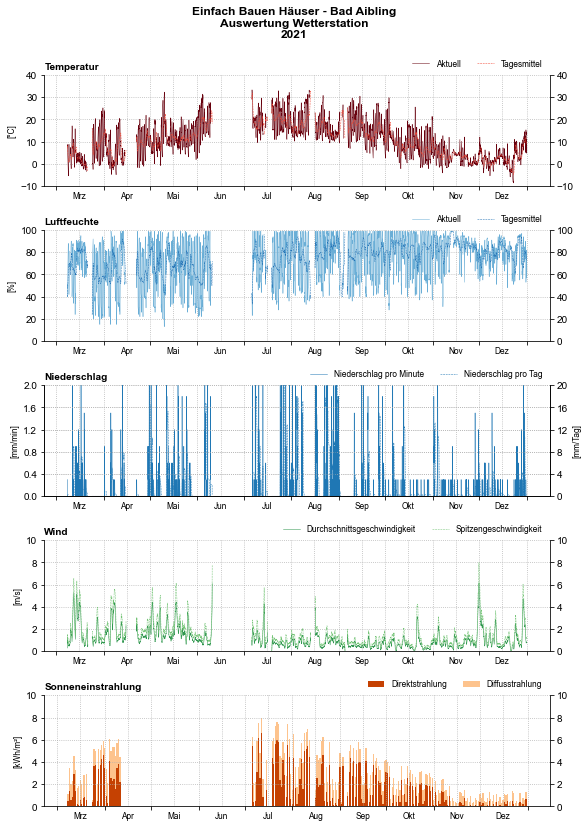

In [5]:
if not os.path.isdir(os.path.join(dir_results,'Wetterstation')):os.makedirs(os.path.join(dir_results,'Wetterstation'))
with PdfPages(os.path.join(dir_results,'Wetterstation','Wetter_jährlich.pdf')) as pdf:
    for date, amb in AMB.groupby(by=AMB.index.year):
        date = dt.date(date, 1, 1)
        fig, axs = plt.subplots(5,1,figsize=DIN['A4'])
        fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\n{date.strftime("%Y")}\n', fontweight = 'bold')
        i=0
        #----#1: Temperaturen ----
        axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[°C]')
        set_ticks(axs[i],-10,40,10)
        axs[i].plot(amb.T_amb,label='Aktuell')
        axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        recolor_lines(axs[i], 'Reds_r', 0 ,0.8)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#2: Luftfeuchte ----
        axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[%]')
        set_ticks(axs[i],0,100,20)
        axs[i].plot(amb.Rh_amb,label='Aktuell')
        axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
        recolor_lines(axs[i], 'Blues', 0.5,1)
        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Niederschlag ----
        # Plot aktueller Niederschlag (pro Minute)
        axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[mm/min]')
        
        axs[i].plot(amb.rain.diff(),label='Niederschlag pro Minute')
        han,lab = axs[i].get_legend_handles_labels()
        axs[i].grid(axis='y', ls = 'dotted')
        i+=1

        #Plot summierter Niederschlag pro Tag

        axs = np.insert(axs,i,axs[i-1].twinx())
        axs[i].set_ylabel('[mm/Tag]')
        axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
        set_ticks(axs[i],0,20,4)
        set_ticks(axs[i-1], 0, 2, 0.4)
        han2,lab2 = axs[i].get_legend_handles_labels()
        lab += lab2
        han += han2
        axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1
        #----#3: Wind ----

        axs[i].set_title('Wind', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[m/s]')
        axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Durchschnittsgeschwindigkeit')  
        axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
        recolor_lines(axs[i], 'Greens_r', 0.3,0.7)
        axs[i].grid(axis='y', ls = 'dotted')
        set_ticks(axs[i],0,10,2)
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
        i+=1

        #----#4: Globalstrahlung ----
        
        axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
        axs[i].set_ylabel('[kWh/m²]')
        set_ticks(axs[i],0,10,2)
        df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

        axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direktstrahlung')
        axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffusstrahlung')

        axs[i].grid(axis='y', ls = 'dotted')
        axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
        axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

        for ax in axs:
            ax.xaxis.set_major_locator(mdates.MonthLocator())
            ax.xaxis.set_major_formatter(ticker.NullFormatter())
            
            ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
            ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))

            for tick in ax.xaxis.get_minor_ticks():
                tick.tick1line.set_markersize(0)
                tick.tick2line.set_markersize(0)
                tick.label1.set_horizontalalignment('center')

            ax.grid(axis='x',which='both', linestyle='dotted')
            ax.spines['bottom'].set_visible(True)
            ax.spines['right'].set_visible(True)
            
        fig.tight_layout()
        pdf.savefig(fig)
        if not ex: break

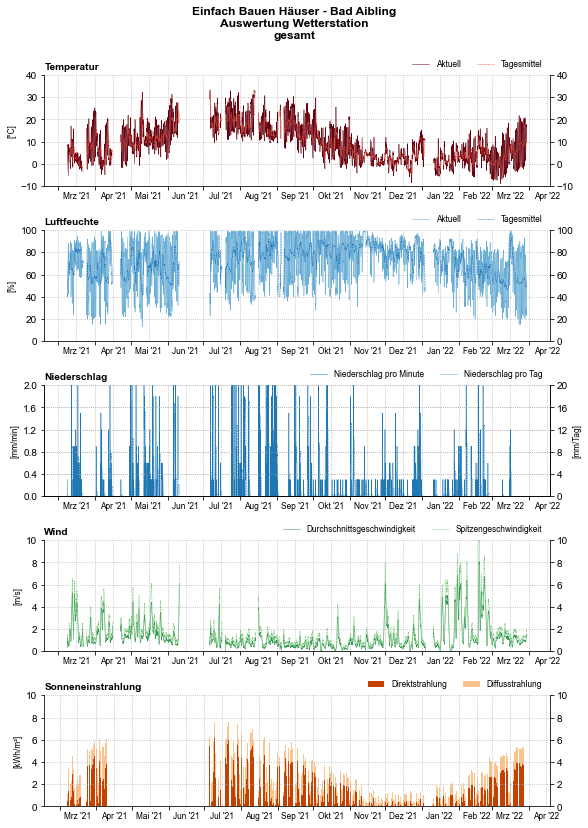

In [6]:
if not os.path.isdir(os.path.join(dir_results,'Wetterstation')):os.makedirs(os.path.join(dir_results,'Wetterstation'))
with PdfPages(os.path.join(dir_results,'Wetterstation','Wetter_gesamt.pdf')) as pdf:
    amb = AMB
    fig, axs = plt.subplots(5,1,figsize=DIN['A4'])
    fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\ngesamt\n', fontweight = 'bold')
    i=0
    #----#1: Temperaturen ----
    axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[°C]')
    set_ticks(axs[i],-10,40,10)
    axs[i].plot(amb.T_amb,label='Aktuell')
    axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
    recolor_lines(axs[i], 'Reds_r', 0 ,0.8)
    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#2: Luftfeuchte ----
    axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[%]')
    set_ticks(axs[i],0,100,20)
    axs[i].plot(amb.Rh_amb,label='Aktuell')
    axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
    recolor_lines(axs[i], 'Blues', 0.5,1)
    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#3: Niederschlag ----
    # Plot aktueller Niederschlag (pro Minute)
    axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[mm/min]')
    
    axs[i].plot(amb.rain.diff(),label='Niederschlag pro Minute')
    han,lab = axs[i].get_legend_handles_labels()
    axs[i].grid(axis='y', ls = 'dotted')
    i+=1

    #Plot summierter Niederschlag pro Tag

    axs = np.insert(axs,i,axs[i-1].twinx())
    axs[i].set_ylabel('[mm/Tag]')
    axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
    set_ticks(axs[i],0,20,4)
    set_ticks(axs[i-1], 0, 2, 0.4)
    han2,lab2 = axs[i].get_legend_handles_labels()
    lab += lab2
    han += han2
    axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#3: Wind ----

    axs[i].set_title('Wind', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[m/s]')
    axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Durchschnittsgeschwindigkeit')  
    axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
    recolor_lines(axs[i], 'Greens_r', 0.3,0.7)
    axs[i].grid(axis='y', ls = 'dotted')
    set_ticks(axs[i],0,10,2)
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #----#4: Globalstrahlung ----
    
    axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[kWh/m²]')
    set_ticks(axs[i],0,10,2)
    df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

    axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direktstrahlung')
    axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffusstrahlung')

    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b '%y"))

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')

        ax.grid(axis='x',which='both', linestyle='dotted')
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    fig.tight_layout()
    pdf.savefig(fig)

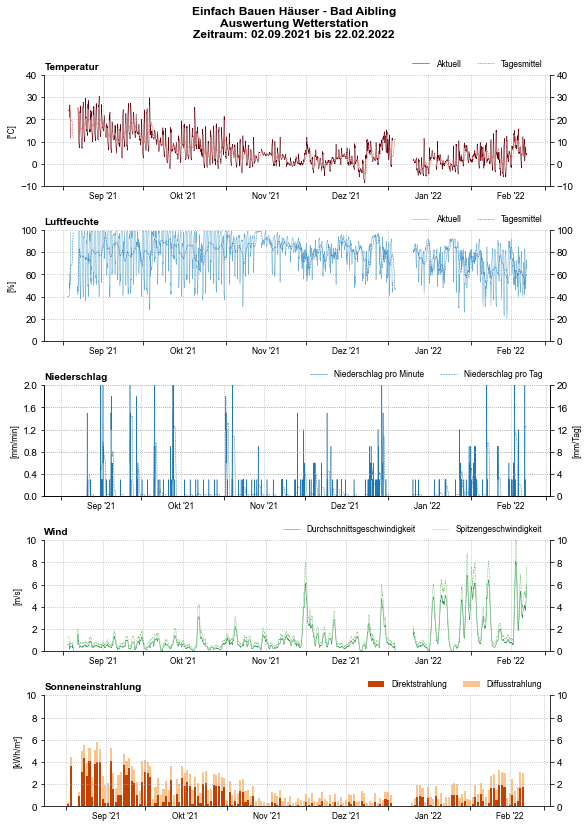

In [7]:
startdate   =   dt.datetime(2021,9,2,tzinfo=tz)
enddate     =   dt.datetime(2022,2,22,tzinfo=tz)

if not os.path.isdir(os.path.join(dir_results,'Wetterstation')):os.makedirs(os.path.join(dir_results,'Wetterstation'))
with PdfPages(os.path.join(dir_results,'Wetterstation','Wetter_Winter.pdf')) as pdf:
    amb = AMB.loc[startdate:enddate]
    fig, axs = plt.subplots(5,1,figsize=DIN['A4'])
    fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nAuswertung Wetterstation\nZeitraum: {startdate.strftime("%d.%m.%Y")} bis {enddate.strftime("%d.%m.%Y")}\n', fontweight = 'bold')
    i=0
    #----#1: Temperaturen ----
    axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[°C]')
    set_ticks(axs[i],-10,40,10)
    axs[i].plot(amb.T_amb,label='Aktuell')
    axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
    recolor_lines(axs[i], 'Reds_r', 0 ,0.8)
    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#2: Luftfeuchte ----
    axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[%]')
    set_ticks(axs[i],0,100,20)
    axs[i].plot(amb.Rh_amb,label='Aktuell')
    axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel')
    recolor_lines(axs[i], 'Blues', 0.5,1)
    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#3: Niederschlag ----
    # Plot aktueller Niederschlag (pro Minute)
    axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[mm/min]')
    
    axs[i].plot(amb.rain.diff(),label='Niederschlag pro Minute')
    han,lab = axs[i].get_legend_handles_labels()
    axs[i].grid(axis='y', ls = 'dotted')
    i+=1

    #Plot summierter Niederschlag pro Tag

    axs = np.insert(axs,i,axs[i-1].twinx())
    axs[i].set_ylabel('[mm/Tag]')
    axs[i].plot(amb.rain.diff().rolling('D').sum(), linestyle='dashed',label='Niederschlag pro Tag')
    set_ticks(axs[i],0,20,4)
    set_ticks(axs[i-1], 0, 2, 0.4)
    han2,lab2 = axs[i].get_legend_handles_labels()
    lab += lab2
    han += han2
    axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#3: Wind ----

    axs[i].set_title('Wind', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[m/s]')
    axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'Durchschnittsgeschwindigkeit')  
    axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
    recolor_lines(axs[i], 'Greens_r', 0.3,0.7)
    axs[i].grid(axis='y', ls = 'dotted')
    set_ticks(axs[i],0,10,2)
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #----#4: Globalstrahlung ----
    
    axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[kWh/m²]')
    set_ticks(axs[i],0,10,2)
    df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000

    axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'Direktstrahlung')
    axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'Diffusstrahlung')

    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b '%y"))

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')
            
        ax.grid(axis='x',which='both', linestyle='dotted')
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    fig.tight_layout()
    pdf.savefig(fig)

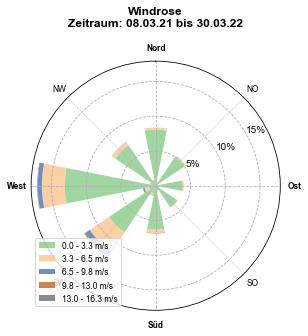

In [8]:
winddir = {'E':4, 'ENE':3, 'ESE':5, 'N':0, 'NE':2, 'NNE':1, 'NNW':15, 'NW':14, 'S':8, 'SE':6, 'SSE':7,
       'SSW':9, 'SW':10, 'W':12, 'WNW':13, 'WSW':11}
winddir = dict(sorted(winddir.items(), key=lambda item: item[1]))
wind = dict(zip(winddir.keys(), np.linspace(0,2*np.pi,16,endpoint=False)))

W =  AMB.loc[:,['winddir','windspeed','gustspeed']]
W['dir'] = W.winddir.replace(wind)

bins = np.linspace(W.windspeed.min(), W.windspeed.max(), 6)
labels = ['{} - {} m/s'.format(round(bins[i-1],1),round(bins[i],1)) for i in range(1,6)]

columns = ['bin{}'.format(i) for i in range(6)]
rose = pd.DataFrame(index=W.winddir.value_counts().index, columns=columns)

for i in range(1,6):
    rose[columns[i]] = W[(W.windspeed > bins[i-1]) & (W.windspeed <= bins[i])].groupby("winddir").size()/W.groupby('winddir').size().sum()
rose = rose*100

rose['theta'] = rose.index
rose.theta.replace(wind,inplace=True)
rose['deg'] =  rose.theta.apply(np.rad2deg)
rose.replace(np.nan,0,inplace=True)

fig, ax = plt.subplots(figsize = INDOC, subplot_kw={'projection': 'polar'})

fig.suptitle(f'Windrose\nZeitraum: {AMB.index.min():%d.%m.%y} bis {AMB.index.max():%d.%m.%y}',fontweight='bold')

w = 2*np.pi/(16)

_colors = plt.cm.Accent(np.linspace(0,1,5))

ax.bar(rose.theta,rose.bin1,width = w, bottom=0, label = labels[0],color=_colors[0],alpha=0.75)
ax.bar(rose.theta,rose.bin2,width = w, bottom=rose.bin1, label = labels[1],color=_colors[1],alpha=0.75)
ax.bar(rose.theta,rose.bin3,width = w, bottom=rose.bin1+rose.bin2, label = labels[2],color=_colors[2],alpha=0.75)
ax.bar(rose.theta,rose.bin4,width = w, bottom=rose.bin1+rose.bin2+rose.bin3, label = labels[3],color=_colors[3],alpha=0.75)
ax.bar(rose.theta,rose.bin5,width = w, bottom=rose.bin1+rose.bin2+rose.bin3+rose.bin4, label = labels[4],color=_colors[4],alpha=0.75)

ax.set_theta_direction(-1)

ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False))
ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False)+0.25*np.pi,minor=True)
ax.set_xticklabels(['NO','SO','SW','NW'],minor=True)
ax.set_xticklabels(['Nord','Ost','Süd','West'],fontweight='bold')

ax.set_theta_zero_location('N')

ax.grid(linestyle='dashed')
ax.grid(linestyle='dotted',which='minor')

ax.set_rlabel_position(60)
ax.legend(loc=3,frameon=True)
ax.yaxis.set_major_locator(ticker.FixedLocator([5,10,15,20]))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))

fig.tight_layout()

if ex:
    export(fig,filepath=os.path.join(dir_results,'Wetterstation'),filename='Windrose_gesamt', extlist=['pdf'])

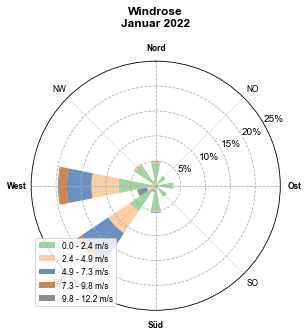

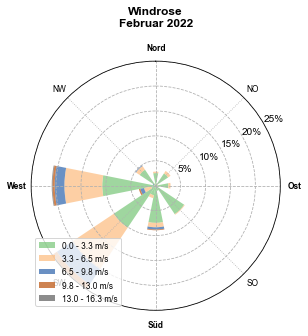

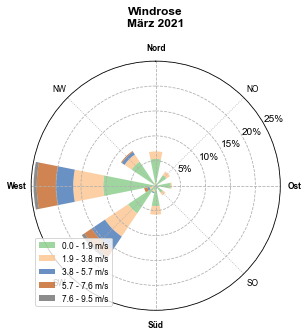

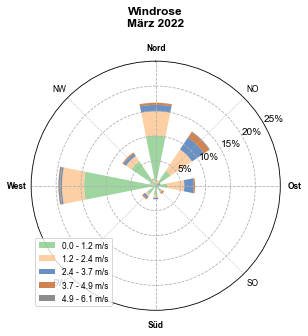

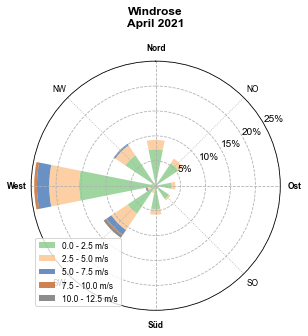

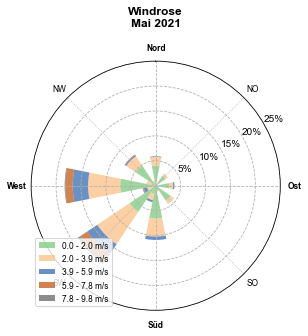

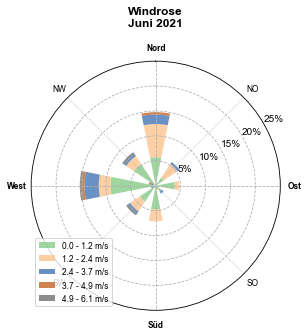

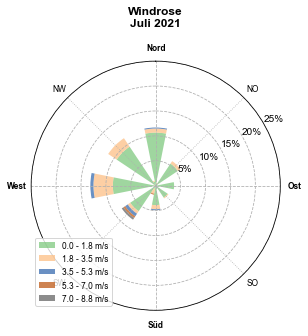

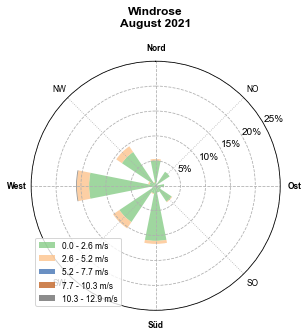

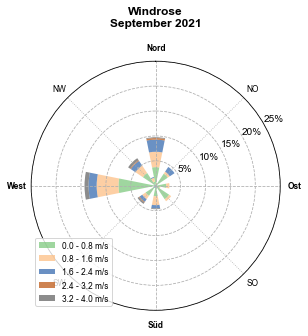

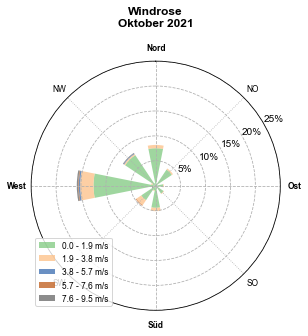

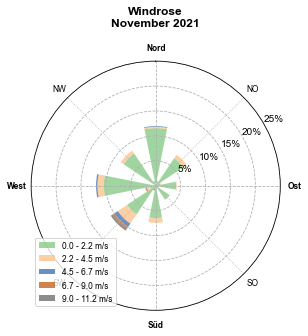

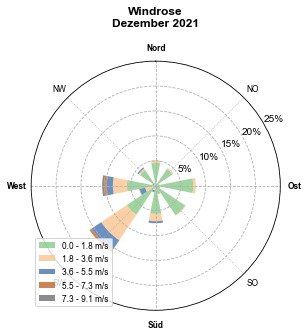

In [9]:
winddir = {'E':4, 'ENE':3, 'ESE':5, 'N':0, 'NE':2, 'NNE':1, 'NNW':15, 'NW':14, 'S':8, 'SE':6, 'SSE':7,
       'SSW':9, 'SW':10, 'W':12, 'WNW':13, 'WSW':11}
winddir = dict(sorted(winddir.items(), key=lambda item: item[1]))
wind = dict(zip(winddir.keys(), np.linspace(0,2*np.pi,16,endpoint=False)))

W =  AMB.loc[:,['winddir','windspeed','gustspeed']]
W['dir'] = W.winddir.replace(wind)

with PdfPages(os.path.join(dir_results,'Wetterstation','Windrose_monatlich.pdf')) as pdf:
    for date, group in W.groupby([W.index.month, W.index.year]):
        date = dt.date(date[1], date[0], 1)
        bins = np.linspace(group.windspeed.min(), group.windspeed.max(), 6)
        labels = ['{} - {} m/s'.format(round(bins[i-1],1),round(bins[i],1)) for i in range(1,6)]

        columns = ['bin{}'.format(i) for i in range(6)]
        rose = pd.DataFrame(index=group.winddir.value_counts().index, columns=columns)

        for i in range(1,6):
            rose[columns[i]] = group[(group.windspeed > bins[i-1]) & (group.windspeed <= bins[i])].groupby("winddir").size()/group.groupby('winddir').size().sum()
        rose = rose*100

        rose['theta'] = rose.index
        rose.theta.replace(wind,inplace=True)
        rose['deg'] =  rose.theta.apply(np.rad2deg)
        rose.replace(np.nan,0,inplace=True)
        fig, ax = plt.subplots(figsize = INDOC, subplot_kw={'projection': 'polar'})

        fig.suptitle(f'Windrose\n{date.strftime("%B %Y")}',fontweight='bold')

        w = 2*np.pi/(16)

        _colors = plt.cm.Accent(np.linspace(0,1,5))

        ax.bar(rose.theta,rose.bin1,width = w, bottom=0, label = labels[0],color=_colors[0],alpha=0.75)
        ax.bar(rose.theta,rose.bin2,width = w, bottom=rose.bin1, label = labels[1],color=_colors[1],alpha=0.75)
        ax.bar(rose.theta,rose.bin3,width = w, bottom=rose.bin1+rose.bin2, label = labels[2],color=_colors[2],alpha=0.75)
        ax.bar(rose.theta,rose.bin4,width = w, bottom=rose.bin1+rose.bin2+rose.bin3, label = labels[3],color=_colors[3],alpha=0.75)
        ax.bar(rose.theta,rose.bin5,width = w, bottom=rose.bin1+rose.bin2+rose.bin3+rose.bin4, label = labels[4],color=_colors[4],alpha=0.75)

        ax.set_theta_direction(-1)

        ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False))
        ax.set_xticks(np.linspace(0,2*np.pi,4,endpoint=False)+0.25*np.pi,minor=True)
        ax.set_xticklabels(['NO','SO','SW','NW'],minor=True)
        ax.set_xticklabels(['Nord','Ost','Süd','West'],fontweight='bold')
        
        ax.set_theta_zero_location('N')

        ax.grid(linestyle='dashed')
        ax.grid(linestyle='dotted',which='minor')

        ax.set_rlabel_position(60)
        ax.legend(loc=3,frameon=True)
        ax.yaxis.set_major_locator(ticker.FixedLocator([5,10,15,20,25]))
        ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
        ax.set_ylim(0,25)
        
        fig.tight_layout()
        pdf.savefig(fig)
        

In [12]:
startdate   =   dt.datetime(2021,9,2, tzinfo=tz)
enddate     =   dt.datetime(2022,2,22, tzinfo=tz)

dfs = []
for year in range(startdate.year, enddate.year+1):
    w = weather109()
    w.read_file(r'.\src\Wetterdaten\TRY2017_Mietraching_extrem.109', year=year)
    w.df.index = pd.to_numeric(w.df.index)
    w.df = PeriodToDatetimeIndex(w.df, w.year)
    w.df.columns = ['direct', 'diffuse', 'T_amb', 'windspeed', 'Rh_amb', 'winddir', 'CCOVER', 'PAMB']
    dfs.append(w.df)
w_df = pd.concat(dfs, axis=0)

if not os.path.isdir(os.path.join(dir_results,'Wetterstation')):os.makedirs(os.path.join(dir_results,'Wetterstation'))
with PdfPages(os.path.join(dir_results,'Wetterstation','Wetter_Simulation.pdf')) as pdf:
    amb = w_df.loc[startdate:enddate]
    ambReal = AMB.loc[startdate:enddate]
    fig, axs = plt.subplots(5,1,figsize=DIN['A4'])
    fig.suptitle(f'Einfach Bauen Häuser - Bad Aibling\nWetterdatensatz: {w.name}\nZeitraum: {startdate.strftime("%d.%m.%Y")} bis {enddate.strftime("%d.%m.%Y")}\n', fontweight = 'bold')
    i=0
    #----#1: Temperaturen ----
    axs[i].set_title('Temperatur', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[°C]')
    set_ticks(axs[i],-10,40,10)
    #axs[i].plot(amb.T_amb,label='TRY', c = plt.cm.Reds(0.7))
    axs[i].plot(amb.T_amb.rolling('D').mean(), linestyle='dashed', label='Tagesmittel (TRY)', c = plt.cm.Reds(1))

    #axs[i].plot(ambReal.T_amb,label='Messwert',c = plt.cm.Reds(0.7), alpha=0.5)
    axs[i].plot(ambReal.T_amb.rolling('D').mean(), linestyle='dashed', label='Tagesmittel (Messwert)', c = plt.cm.Reds(1), alpha=0.5)

    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #----#2: Luftfeuchte ----
    axs[i].set_title('Luftfeuchte', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[%]')
    set_ticks(axs[i],0,100,20)
    #axs[i].plot(amb.Rh_amb,label='TRY')
    axs[i].plot(amb.Rh_amb.rolling('D').mean(), linestyle='dashed', label='Tagesmittel (TRY)')

    #axs[i].plot(ambReal.Rh_amb,label='Messwert')
    axs[i].plot(ambReal.Rh_amb.rolling('D').mean(), linestyle='dashed',label='Tagesmittel (Messwert)')

    recolor_lines(axs[i], 'Blues', 0.5,1)
    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1
    #----#3: Niederschlag ----
    # Plot aktueller Niederschlag (pro Minute)
    axs[i].set_title('Niederschlag', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[mm/min]')
    try:
        axs[i].plot(amb.rain,label='TRY (pro Stunde)')
        axs[i].plot(ambReal.rain.diff(),label='Messwert (pro Stunde)')
        han,lab = axs[i].get_legend_handles_labels()
        axs[i].grid(axis='y', ls = 'dotted')
        i+=1

        #Plot summierter Niederschlag pro Tag

        axs = np.insert(axs,i,axs[i-1].twinx())
        axs[i].set_ylabel('[mm/Tag]')
        axs[i].plot(amb.rain.rolling('D').sum(), linestyle='dashed',label='TRY (pro Tag)')
        axs[i].plot(ambReal.rain.rolling('D').sum(), linestyle='dashed',label='Messwert (pro Tag)')
        set_ticks(axs[i],0,20,4)
        set_ticks(axs[i-1], 0, 2, 0.4)
        han2,lab2 = axs[i].get_legend_handles_labels()
        lab += lab2
        han += han2
        axs[i].legend(labels = lab, handles = han, loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    except AttributeError:
        axs[i].text(0.5,0.5,'Wetterdatensatz enthält keine Informationen zum Niederschlag.',
                    style='normal', 
                    ha = 'center', 
                    va = 'center',
                    transform=axs[i].transAxes,
                    bbox=eb_bbox, 
                    )
    i+=1

    #----#3: Wind ----

    axs[i].set_title('Wind', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[m/s]')
    axs[i].plot(amb.windspeed.rolling('D').mean(), label = 'TRY (Tagesschnitt)')
    axs[i].plot(ambReal.windspeed.rolling('D').mean(), label = 'Messwert (Tagesschnitt)', linestyle='dashed')
    #axs[i].plot(amb.gustspeed.rolling('D').mean(),label = 'Spitzengeschwindigkeit',linestyle='dashed')  
    recolor_lines(axs[i], 'Greens_r', 0.3,0.7)
    axs[i].grid(axis='y', ls = 'dotted')
    set_ticks(axs[i],0,10,2)
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)
    i+=1

    #----#4: Globalstrahlung ----
    
    axs[i].set_title('Sonneneinstrahlung', fontweight = 'bold',loc='left')
    axs[i].set_ylabel('[kWh/m²]')
    set_ticks(axs[i],0,10,2)

    df_p = amb[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
    axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Oranges(0.8), label = 'TRY (Direkt)', alpha=1)
    axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Oranges(0.3), label = 'TRY (Diffus)', alpha=1)

    df_p = ambReal[['direct','diffuse']].resample('H').mean().resample('D').sum()/1000
    axs[i].bar(df_p.index, df_p['direct'], bottom = 0, color=plt.cm.Greens(0.8), label = 'Messdaten (Direkt)', alpha=0.5)
    axs[i].bar(df_p.index, df_p['diffuse'], bottom = df_p['direct'], color=plt.cm.Greens(0.3), label = 'Messdaten (Diffus)', alpha=0.5)

    axs[i].grid(axis='y', ls = 'dotted')
    axs[i].tick_params(labelleft=True, labelright=True, left=True, right=True)
    axs[i].legend(loc='center right',ncol=99,bbox_to_anchor=(1,1.1),frameon=False)

    for ax in axs:
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(ticker.NullFormatter())
        
        ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b '%y"))

        for tick in ax.xaxis.get_minor_ticks():
            tick.tick1line.set_markersize(0)
            tick.tick2line.set_markersize(0)
            tick.label1.set_horizontalalignment('center')
            
        ax.grid(axis='x',which='both', linestyle='dotted')
        ax.spines['bottom'].set_visible(True)
        ax.spines['right'].set_visible(True)
        
    fig.tight_layout()
    pdf.savefig(fig)
    #fig.savefig(os.path.join(dir_results,'Wetterstation','Wetter_Simulation.png'), dpi=300)

TypeError: 'zoneinfo.ZoneInfo' object is not callable